In [4]:
import pandas as pd
import os
os.chdir(r"C:\Users\Gyu\Desktop\mywork\FastOnline\5. 머신러닝 모델의 성능 향상을 위한 전처리\데이터")

### 변수 분포
특징과 라벨 간 비선형 관계가 존재한다면 적절한 전처리를 통해 모델 성능을 높일 수 있음.

가장 이상적인 방안은 그래프를 통해 적절한 특징 변환 수행


#### 이상치 제거
1. IQR 규칙

In [5]:
df = pd.read_csv("glass.csv")
X = df.drop(['Glass_type'], axis = 1)
Y = df['Glass_type']

from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y)
Train_X.shape

(160, 8)

In [6]:
import numpy as np
def IQR_rule(val_list): # 한 특징에 포함된 값 (열 벡터)
    # IQR 계산    
    Q1 = np.quantile(val_list, 0.25)
    Q3 = np.quantile(val_list, 0.75)
    IQR = Q3 - Q1
    
    # IQR rule을 위배하지 않는 bool list 계산 (True: 이상치 X, False: 이상치 O)
    not_outlier_condition = (Q3 + 1.5 * IQR > val_list) & (Q1 - 1.5 * IQR < val_list)
    return not_outlier_condition

conditions = Train_X.apply(IQR_rule) # apply를 이용하여 모든 컬럼에 IQR rule 함수 적용
conditions

,RI,Na,Mg,Al,Si,K,Ca,Fe
83,True,False,True,True,True,True,False,True
72,True,True,True,True,True,True,True,True
196,True,True,True,True,True,True,True,True
164,True,True,True,True,True,True,True,True
146,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...
185,True,True,True,True,True,True,True,True
34,True,True,True,True,True,True,True,True
37,True,True,True,True,True,True,True,True
131,True,True,True,True,True,True,True,False


In [7]:
total_condition = conditions.sum(axis = 1) == len(Train_X.columns) # 하나라도 IQR 규칙을 위반하는 요소를 갖는 레코드를 제거하기 위한 규칙
Train_X = Train_X.loc[total_condition] # 이상치 제거
Train_X.shape

(118, 8)

#### DBSCAN을 활용한 처리
군집에 속하지 않은 샘플을 이상치라고 간주함, 파라미터 튜닝이 쉽지 않음.

- eps : 이웃이라 판단하는 반경
- min_samples : 중심점이라 판단하기 위해 eps 내에 들어와야 하는 최소 샘플 수
- metric : 거리 척도

label에서 -1이 나오면 이상치

In [8]:
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y)

In [9]:
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
DM = cdist(Train_X, Train_X) # 거리 행렬 => DBSCAN의 파라미터를 설정하기 위함
np.quantile(DM, 0.1) # 샘플 간 거리의 10% quantile이 0.6622정도임을 확인

0.6647334426608053

In [10]:
cluster_model = DBSCAN(eps = 0.67, min_samples = 3).fit(Train_X)
print(sum(cluster_model.labels_ == -1)) 
# 34개가 이상치로 판단 => 이정도면 너무 많은 양이 아닌가?? => 파라미터 조정

34


In [11]:
cluster_model = DBSCAN(eps = 2, min_samples = 3).fit(Train_X)
print(sum(cluster_model.labels_ == -1)) # 9개 정도면 괜찮은 양이라고 판단하여 삭제 수행

9


### 특징 간 상관성 제거
- 회귀, svm 등에서 wx+b 선형식이 모델에 포함되는 경우, 상관성이 높으면 parameter 추정이 어려움.(추정할 때마다 결과가 달라짐)
- 트리 모델의 경우도 예측 성능에 영향을 받지 않지만 설명력에 크게 영향을 받을 수 있음.

<br>

#### 해결 방법
1. VIF

    - 한 특징을 라벨로 간주하고 해당 라벨을 예측하는데 다른 특징을 사용한 회귀모델이 높은 R-squared를 보이는 경우 상관이 있다고 판단.
    - 높은 순서대로 제거하거나 10 이상일 때 주로 삭제
    
2. 주성분 분석
    - 특징이 서로 직교하도록 만듬
    - 분산의 대부분을 설명하는 특징들만 사용하여 차원 축소 기능
    

In [21]:
df = pd.read_csv("abalone.csv")
X = df.drop(['Age'], axis = 1)
Y = df['Age']
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y)

In [13]:
Train_X.corr()

,Length,Diameter,Height,Wholeweight,Shuckedweight,Visceraweight,Shellweight
Length,1.000000,0.986318,0.899562,0.924378,0.895568,0.901918,0.896407
Diameter,0.986318,1.000000,0.907250,0.924476,0.890892,0.897907,0.904024
Height,0.899562,0.907250,1.000000,0.886326,0.833720,0.863684,0.887594
Wholeweight,0.924378,0.924476,0.886326,1.000000,0.968404,0.965470,0.955370
Shuckedweight,0.895568,0.890892,0.833720,0.968404,1.000000,0.929868,0.880252
Visceraweight,0.901918,0.897907,0.863684,0.965470,0.929868,1.000000,0.905590
Shellweight,0.896407,0.904024,0.887594,0.955370,0.880252,0.905590,1.000000


In [22]:
# VIF 계산
from sklearn.linear_model import LinearRegression as LR
VIF_dict = dict()
for col in Train_X.columns:
    model = LR().fit(Train_X.drop([col], axis = 1), Train_X[col])
    r2 = model.score(Train_X.drop([col], axis = 1), Train_X[col]) # LinearRegression의 score가 r2 점수임
    VIF = 1 / (1 - r2)
    VIF_dict[col] = VIF

VIF_dict # Height를 제외하곤 VIF가 모두 높으므로, 이러한 상황에서는 사실 PCA를 사용하는 것이 바람직

{'Length': 41.844340162372255,
 'Diameter': 42.865128679025815,
 'Height': 3.2084546611065634,
 'Wholeweight': 106.16626028506063,
 'Shuckedweight': 27.807961288270867,
 'Visceraweight': 17.120768238797694,
 'Shellweight': 21.102383108075458}

In [23]:
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.metrics import mean_absolute_error as MAE

# VIF 점수가 30점 미만인 특징만 사용하였을 때 
selected_features = [key for key, val in VIF_dict.items() if val < 30] 
model = MLP(random_state = 2313, max_iter = 500)
model.fit(Train_X[selected_features], Train_Y)
pred_Y = model.predict(Test_X[selected_features])
score = MAE(Test_Y, pred_Y)
print(score)

1.6141911983653163


In [16]:
from sklearn.decomposition import PCA
PCA_model = PCA(n_components = 3).fit(Train_X)

Train_Z = PCA_model.transform(Train_X)
Test_Z = PCA_model.transform(Test_X)

print(Train_Z.shape)

(3132, 3)


In [17]:
model = MLP(random_state = 2313, max_iter = 500)
model.fit(Train_Z, Train_Y)
pred_Y = model.predict(Test_Z)
score = MAE(Test_Y, pred_Y)
print(score)

1.4964126426048892


### 변수 치우침 제거

보통 왜도의 절대값이 1.5 이상이면 치우쳤다고 판단함.

해결 방안
1. log(x-min(x)+1)
2. sqrt(x-min(x))

In [33]:
df = pd.read_csv("Sonar_Mines_Rocks.csv")
X = df.drop('Y', axis = 1)
Y = df['Y']
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y)

In [26]:
Train_X.skew() # 왜도 확인 

Band1     1.960073
Band2     2.008445
Band3     2.650155
Band4     3.488549
Band5     2.176872
Band6     0.986641
Band7     0.720030
Band8     1.395150
Band9     1.526546
Band10    1.184597
Band11    0.914194
Band12    0.416211
Band13    0.696595
Band14    1.102455
Band15    0.840225
Band16    0.771143
Band17    0.770226
Band18    0.624335
Band19    0.361360
Band20   -0.018053
Band21   -0.199418
Band22   -0.437606
Band23   -0.638094
Band24   -0.704402
Band25   -0.759193
Band26   -0.634451
Band27   -0.536620
Band28   -0.528471
Band29   -0.388967
Band30   -0.124225
Band31    0.224132
Band32    0.220876
Band33    0.504556
Band34    0.558918
Band35    0.596135
Band36    0.643940
Band37    0.718361
Band38    1.070378
Band39    0.966044
Band40    0.944449
Band41    0.950281
Band42    0.891004
Band43    0.907727
Band44    1.269887
Band45    1.359363
Band46    1.711710
Band47    1.747855
Band48    1.272086
Band49    1.248962
Band50    1.795988
Band51    3.030499
Band52    2.298914
Band53    0.

<AxesSubplot:>

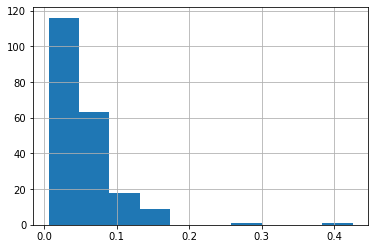

In [27]:
%matplotlib inline
df['Band4'].hist()

In [34]:
Train_Y.replace({"M":-1, "R":1}, inplace = True)
Test_Y.replace({"M":-1, "R":1}, inplace = True)

In [29]:
# 원본 데이터로 모델링
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier as MLP
model = MLP(random_state = 153, max_iter = 1000).fit(Train_X, Train_Y)
pred_Y = model.predict(Test_X)
score = f1_score(Test_Y, pred_Y)
print(score)

0.8333333333333334


In [35]:
# 왜도 기반 치우친 변수 제거 
import numpy as np
biased_variables = Train_X.columns[Train_X.skew().abs() > 1.5] # 왜도의 절대값이 1.5 이상인 컬럼만 가져오기

In [36]:
Train_X[biased_variables] = Train_X[biased_variables] - Train_X[biased_variables].min() + 1
Train_X[biased_variables] = np.log10(Train_X[biased_variables])

C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\pandas\core\frame.py:3062: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [37]:
# 치우침 제거 후 모델 평가
model = MLP(random_state = 153, max_iter = 1000).fit(Train_X, Train_Y)

# 테스트도 데이터도 같은 방법으로 전처리를 수행
Test_X[biased_variables] = Test_X[biased_variables] - Test_X[biased_variables].min() + 1
Test_X[biased_variables] = Test_X[biased_variables].apply(np.log)

pred_Y = model.predict(Test_X)
score = f1_score(Test_Y, pred_Y)
print(score)
# 오잉 안좋넹....

0.7368421052631579


C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\pandas\core\frame.py:3062: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### 변수 스케일링

모델이 스케일의 크고 작음에 많은 영향을 받음. 나이브 베이즈, 의사결정(이진)트리 는 스케일에 영향받지 않음

1. Standard : (x-u)/v
    - 정규 분포를 가정하는 회귀, 로지스틱 등에 좋음
2. MinMax : (x-min(x))/(max(x)-min(x))
    - 특정 분포를 가정하지 않는 신경망, kNN에 좋음


In [38]:
df = pd.read_csv("baseball.csv")
X = df.drop('Salary', axis = 1)
Y = df['Salary']
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y)

Train_X.max() - Train_X.min()

Batting_average              0.394
On-base_percentage           0.423
Runs                       133.000
Hits                       215.000
Doubles                     49.000
Triples                     15.000
HomeRuns                    44.000
Runs_batted_in             133.000
Walks                      138.000
Strike-Outs                174.000
Stolen_bases                76.000
Errors                      31.000
Free_agency_eligibility      1.000
Free_agent                   1.000
Arbitration_eligibility      1.000
Arbitration                  1.000
dtype: float64

In [39]:
# 스케일링 전에 성능 확인
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.metrics import mean_absolute_error as MAE
model = KNN().fit(Train_X, Train_Y)
pred_Y = model.predict(Test_X)

score = MAE(Test_Y, pred_Y)
print(score)

616.6658823529411


In [40]:
# 스케일링 수행
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(Train_X)
s_Train_X = scaler.transform(Train_X)
s_Test_X = scaler.transform(Test_X)

In [41]:
model = KNN().fit(s_Train_X, Train_Y)
pred_Y = model.predict(s_Test_X)

score = MAE(Test_Y, pred_Y)
print(score)

433.7905882352941


스케일링을 헤도 개선되지 않으면 변수 자체가 의미없을 수도 있는 등의 이유를 생각!